# 《人工神经网络理论、设计及应用》代码实践-第五章 径向基函数神经网络
<hr>

### 5.2 正则化RBF网络

#### Page89 正则化RBF的结构及特点
- 下面程序与书中径向基函数数量规则一致，增加了可选随机训练样本修改、重训练按钮。
- 可以观察到，同样的训练样本数量，其分布对训练后网络拟合测试数据能力的影响。

In [1]:
# 正则化RBF，径向基函数数量等于输入训练样本数量

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib qt5

# 定义径向基函数
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * np.sum((x - c)**2, axis=1))

# 定义RBF网络模型
class RBFNetwork:
    def __init__(self, k, lr=0.01, epochs=1000, rbf=rbf, beta=0.001):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.beta = beta
        
    def fit(self, X, y):
        from sklearn.cluster import KMeans
        # 使用KMeans初始化中心点
        if self.k > 1:  # 如果只有一个中心点，不需要KMeans
            kmeans = KMeans(n_clusters=self.k, random_state=42).fit(X)
            self.centers = kmeans.cluster_centers_
        else:
            self.centers = X
            
        # 计算宽度（这里根据中心点之间的距离自动调整）
        if self.k > 1:
            dists = []
            for i in range(self.k):
                for j in range(i + 1, self.k):
                    dist = np.linalg.norm(self.centers[i] - self.centers[j])
                    if dist > 0:  # 排除重合的中心点
                        dists.append(dist)
            avg_dist = np.mean(dists)
            self.sigmas = np.ones(self.k) * avg_dist * 0.5  # 调整因子可以根据需要改变
        else:
            self.sigmas = [1]  # 对于单个中心点，默认宽度为1

        # 前向传播计算隐层输出
        H = np.array([self.rbf(X, self.centers[i], self.sigmas[i]) for i in range(self.k)]).T
        
        # 添加偏置项
        H = np.hstack([H, np.ones((H.shape[0], 1))])
        
        # 正则化求解线性方程组
        W = np.linalg.solve(H.T @ H + self.beta * np.eye(H.shape[1]), H.T @ y)
        self.W = W[:-1]
        self.bias = W[-1]

    def predict(self, X):
        H = np.array([self.rbf(X, self.centers[i], self.sigmas[i]) for i in range(self.k)]).T
        H = np.hstack([H, np.ones((H.shape[0], 1))])
        return H @ np.append(self.W, self.bias)

# 初始化测试集
np.random.seed(42)
X_test = np.linspace(-6, 6, 100).reshape(-1, 1)
y_test = np.sin(X_test) + 0.1 * np.random.randn(*X_test.shape)

# 创建图表和子图
fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.25, bottom=0.35)

line_train, = ax.plot([], [], 'o', color='blue', label='Training Samples')
line_test, = ax.plot([], [], 'x', color='green', label='Test Samples')
line_pred, = ax.plot([], [], '-', color='red', label='Prediction')

rbf_lines = []
for _ in range(10):  # 预先创建足够多的线条以适应最大可能的RBF数量
    line, = ax.plot([], [], '--', alpha=0.7)
    rbf_lines.append(line)

vertical_lines = []
for _ in range(10):  # 同样预先创建足够的垂线
    line = ax.axvline(x=0, linestyle='--', color='gray', alpha=0.5, visible=False)
    vertical_lines.append(line)

ax.legend()
ax.set_title('RBF Network Fit with Training and Test Samples')
ax.set_xlabel('Input')
ax.set_ylabel('Output')

# 创建滑动条和按钮
ax_slider = plt.axes([0.25, 0.2, 0.65, 0.03])
slider = Slider(ax_slider, 'Train Samples', 5, 10, valinit=5, valstep=1)

ax_button = plt.axes([0.8, 0.05, 0.1, 0.04])
button = Button(ax_button, 'Re-train')

def update_plot():
    global rbfnet
    # 更新训练数据
    n_train_samples = int(slider.val)
    X_train = np.sort(np.random.uniform(-6, 6, n_train_samples)).reshape(-1, 1)
    y_train = np.sin(X_train) + 0.1 * np.random.randn(*X_train.shape)

    # 更新RBF网络
    rbfnet = RBFNetwork(k=n_train_samples, lr=0.01, epochs=1000, beta=0.001)
    rbfnet.fit(X_train, y_train.ravel())

    # 更新预测值
    predictions = rbfnet.predict(X_test)
    
    # 更新绘图数据
    line_train.set_data(X_train, y_train)
    line_test.set_data(X_test, y_test)
    line_pred.set_data(X_test, predictions)

    # 更新RBF贡献曲线和中心垂线
    for i, line in enumerate(rbf_lines[:n_train_samples]):
        line.set_data(X_test, rbfnet.W[i] * rbf(X_test, rbfnet.centers[i], rbfnet.sigmas[i]))
        line.set_label(f'RBF {i+1}')
    for i, line in enumerate(rbf_lines[n_train_samples:], start=n_train_samples):
        line.set_data([], [])
        line.set_label('_nolegend_')  # 移除多余的图例项
    
    for i, vline in enumerate(vertical_lines[:n_train_samples]):
        vline.set_xdata([rbfnet.centers[i], rbfnet.centers[i]])
        vline.set_visible(True)
    for vline in vertical_lines[n_train_samples:]:
        vline.set_visible(False)

    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw_idle()

def on_slider_change(val):
    update_plot()

def on_button_click(event):
    update_plot()

slider.on_changed(on_slider_change)
button.on_clicked(on_button_click)

# 初始绘制
update_plot()
plt.show()

libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


### 5.3 广义RBF神经网络

#### Page91 广义RBF

In [2]:
# Page91 广义RBF，采用自适应调整径向基函数中心方法

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib qt5

# 定义径向基函数
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * np.sum((x - c)**2, axis=1))

# 定义RBF网络模型
class RBFNetwork:
    def __init__(self, k, lr_center=0.01, lr_weight=0.01, lr_sigma=0.001, epochs=1000, rbf=rbf, beta=0.01):
        self.k = k
        self.lr_center = lr_center  # 中心点的学习率
        self.lr_weight = lr_weight  # 权重的学习率
        self.lr_sigma = lr_sigma    # 宽度的学习率
        self.epochs = epochs
        self.rbf = rbf
        self.beta = beta
        
    def fit(self, X, y):
        # 随机初始化中心点
        input_range = np.max(X) - np.min(X)
        self.centers = np.random.uniform(np.min(X), np.max(X), (self.k, X.shape[1]))
        
        # 计算宽度（根据中心点之间的距离自动调整）
        if self.k > 1:
            dists = []
            for i in range(self.k):
                for j in range(i + 1, self.k):
                    dist = np.linalg.norm(self.centers[i] - self.centers[j])
                    if dist > 0:  # 排除重合的中心点
                        dists.append(dist)
            avg_dist = np.mean(dists)
            self.sigmas = [avg_dist / np.sqrt(2 * self.k)] * self.k  # 更科学的初始化
        else:
            self.sigmas = [1]  # 对于单个中心点，默认宽度为1

        # 初始化权重和偏置项
        self.W = np.random.randn(self.k)
        self.bias = np.random.randn()

        # 梯度下降优化过程
        for epoch in range(self.epochs):
            # 前向传播
            H = np.array([self.rbf(X, self.centers[i], self.sigmas[i]) for i in range(self.k)]).T
            predictions = H @ self.W + self.bias
            
            # 计算误差
            error = predictions - y
            
            # 更新权重和偏置项
            dW = H.T @ error + self.beta * self.W
            dbias = np.sum(error) + self.beta * self.bias
            self.W -= self.lr_weight * dW
            self.bias -= self.lr_weight * dbias

            # 更新中心点位置
            for i in range(self.k):
                dh_dc = (X - self.centers[i]) / self.sigmas[i]**2
                derror_dc = np.sum((error * self.W[i]).reshape(-1, 1) * dh_dc, axis=0)
                self.centers[i] -= self.lr_center * derror_dc

            # 更新宽度参数
            for i in range(self.k):
                dh_ds = ((X - self.centers[i])**2 / self.sigmas[i]**3) * H[:, i].reshape(-1, 1)
                derror_ds = np.sum((error * self.W[i]).reshape(-1, 1) * dh_ds, axis=0)
                self.sigmas[i] -= self.lr_sigma * np.mean(derror_ds)

    def predict(self, X):
        H = np.array([self.rbf(X, self.centers[i], self.sigmas[i]) for i in range(self.k)]).T
        return H @ self.W + self.bias

# 初始化测试集
np.random.seed(42)
X_test = np.linspace(-6, 6, 100).reshape(-1, 1)
y_test = np.sin(X_test) + 0.1 * np.random.randn(*X_test.shape)

# 创建图表和子图
fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.25, bottom=0.4)

line_train, = ax.plot([], [], 'o', color='blue', label='Training Samples')
line_test, = ax.plot([], [], 'x', color='green', label='Test Samples')
line_pred, = ax.plot([], [], '-', color='red', label='Prediction')

rbf_lines = []
for _ in range(10):  # 预先创建足够多的线条以适应最大可能的RBF数量
    line, = ax.plot([], [], '--', alpha=0.7)
    rbf_lines.append(line)

vertical_lines = []
for _ in range(10):  # 同样预先创建足够的垂线
    line = ax.axvline(x=0, linestyle='--', color='gray', alpha=0.5, visible=False)
    vertical_lines.append(line)

ax.legend()
ax.set_title('Adaptive Generalized RBF Network Fit with Training and Test Samples')
ax.set_xlabel('Input')
ax.set_ylabel('Output')

# 创建滑动条和按钮
ax_slider_train = plt.axes([0.25, 0.25, 0.65, 0.03])
slider_train = Slider(ax_slider_train, 'Train Samples', 50, 500, valinit=100, valstep=1)

ax_slider_rbf = plt.axes([0.25, 0.2, 0.65, 0.03])
slider_rbf = Slider(ax_slider_rbf, 'RBF Count', 1, 10, valinit=5, valstep=1)

ax_button = plt.axes([0.8, 0.05, 0.1, 0.04])
button = Button(ax_button, 'Re-train')

global rbfnet

def update_plot():
    global rbfnet
    # 更新训练数据
    n_train_samples = int(slider_train.val)
    X_train = np.sort(np.random.uniform(-6, 6, n_train_samples)).reshape(-1, 1)
    y_train = np.sin(X_train) + 0.1 * np.random.randn(*X_train.shape)

    # 更新RBF网络
    k = int(slider_rbf.val)  # 从滑动条获取RBF数量
    rbfnet = RBFNetwork(k=k, lr_center=0.001, lr_weight=0.01, lr_sigma=0.001, epochs=1000, beta=0.01)
    rbfnet.fit(X_train, y_train.ravel())

    # 更新预测值
    predictions = rbfnet.predict(X_test)
    
    # 更新绘图数据
    line_train.set_data(X_train, y_train)
    line_test.set_data(X_test, y_test)
    line_pred.set_data(X_test, predictions)

    # 更新RBF贡献曲线和中心垂线
    for i, line in enumerate(rbf_lines[:rbfnet.k]):
        line.set_data(X_test, rbfnet.W[i] * rbf(X_test, rbfnet.centers[i], rbfnet.sigmas[i]))
        line.set_label(f'RBF {i+1}')
    for i, line in enumerate(rbf_lines[rbfnet.k:], start=rbfnet.k):
        line.set_data([], [])
        line.set_label('_nolegend_')  # 移除多余的图例项
    
    for i, vline in enumerate(vertical_lines[:rbfnet.k]):
        vline.set_xdata([rbfnet.centers[i], rbfnet.centers[i]])
        vline.set_visible(True)
    for vline in vertical_lines[rbfnet.k:]:
        vline.set_visible(False)

    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw_idle()

def on_slider_change(val):
    update_plot()

def on_button_click(event):
    update_plot()

slider_train.on_changed(on_slider_change)
slider_rbf.on_changed(on_slider_change)
button.on_clicked(on_button_click)

# 初始绘制
update_plot()
plt.show()

#### Page90 5.3.1模式的可分性，径向基函数解决XOR数据可分，增加了2维可视化

Predictions: [-2.77555756e-17  1.00000000e+00  1.00000000e+00  8.32667268e-17]


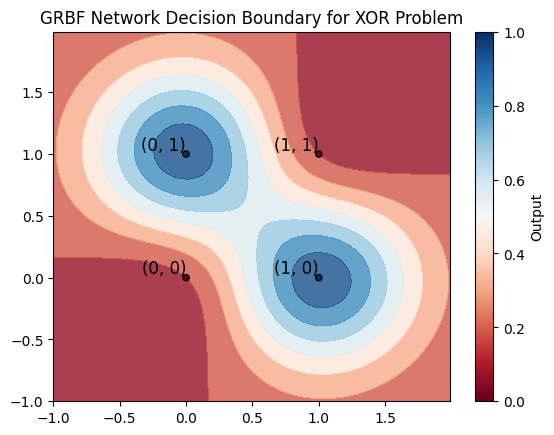

In [1]:
# Page90 5.3.1模式的可分性，2维可视化

import numpy as np
import matplotlib.pyplot as plt

class GRBFNetwork:
    def __init__(self, centers, sigmas):
        self.centers = centers  # 中心点
        self.sigmas = sigmas     # 宽度参数
        self.weights = None      # 输出权重

    def grbf(self, x, c, sigma):
        """计算广义径向基函数"""
        return np.exp(-np.linalg.norm(x - c)**2 / (2 * sigma**2))

    def fit(self, X, y):
        """拟合模型"""
        m = len(X)
        # 创建设计矩阵
        G = np.zeros((m, len(self.centers)))
        for i in range(m):
            for j in range(len(self.centers)):
                G[i, j] = self.grbf(X[i], self.centers[j], self.sigmas[j])

        # 使用最小二乘法计算权重
        self.weights = np.linalg.pinv(G).dot(y)

    def predict(self, X):
        """预测新数据"""
        m = len(X)
        G = np.zeros((m, len(self.centers)))
        for i in range(m):
            for j in range(len(self.centers)):
                G[i, j] = self.grbf(X[i], self.centers[j], self.sigmas[j])
        return G.dot(self.weights)

def plot_decision_boundary_with_labels(model, X, y, title="Decision Boundary"):
    """绘制决策边界，并标注数据点"""
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.RdBu)
    
    # 添加训练数据点的标签
    for i, txt in enumerate([f'({x[0]}, {x[1]})' for x in X]):
        plt.text(X[i, 0], X[i, 1], txt, size=12, color='black', ha='right', va='bottom')
    
    plt.title(title)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    # 显示图例
    plt.colorbar(scatter, label='Output')
    plt.show()

# XOR数据集
X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_train = np.array([0, 1, 1, 0])  # XOR目标值

# 预定义的中心点和宽度
centers = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])  # 使用训练样本作为中心点
sigmas = np.array([0.5, 0.5, 0.5, 0.5])  # 固定宽度

# 创建并训练GRBF网络
grbf_network = GRBFNetwork(centers, sigmas)
grbf_network.fit(X_train, y_train[:, np.newaxis])

# 测试/预测
predictions = grbf_network.predict(X_train)
print("Predictions:", predictions.flatten())

# 可视化决策边界并标注数据点
plot_decision_boundary_with_labels(grbf_network, X_train, y_train, 
                                   "GRBF Network Decision Boundary for XOR Problem")

#### Page90 5.3.1模式的可分性，三维可视化

Predictions: [-2.77555756e-17  1.00000000e+00  1.00000000e+00  8.32667268e-17]


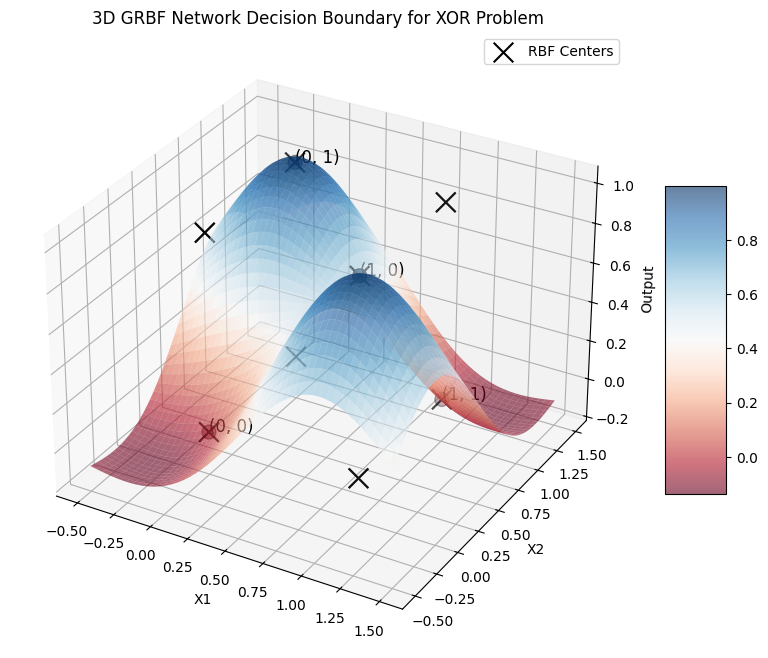

In [1]:
# Page90 5.3.1模式的可分性，三维可视化

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib qt5

class GRBFNetwork:
    def __init__(self, centers, sigmas):
        self.centers = centers  # 中心点
        self.sigmas = sigmas     # 宽度参数
        self.weights = None      # 输出权重

    def grbf(self, x, c, sigma):
        """计算广义径向基函数"""
        return np.exp(-np.linalg.norm(x - c)**2 / (2 * sigma**2))

    def fit(self, X, y):
        """拟合模型"""
        m = len(X)
        # 创建设计矩阵
        G = np.zeros((m, len(self.centers)))
        for i in range(m):
            for j in range(len(self.centers)):
                G[i, j] = self.grbf(X[i], self.centers[j], self.sigmas[j])

        # 使用最小二乘法计算权重
        self.weights = np.linalg.pinv(G).dot(y)

    def predict(self, X):
        """预测新数据"""
        m = len(X)
        G = np.zeros((m, len(self.centers)))
        for i in range(m):
            for j in range(len(self.centers)):
                G[i, j] = self.grbf(X[i], self.centers[j], self.sigmas[j])
        return G.dot(self.weights)

def plot_3d_decision_boundary(model, X, y, title="3D Decision Boundary"):
    """绘制3D决策边界"""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # 预测网格上的值
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制表面（决策边界）
    surf = ax.plot_surface(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.6, linewidth=0, antialiased=True)
    
    # 绘制训练数据点
    scatter = ax.scatter(X[:, 0], X[:, 1], y, c=y, s=100, edgecolor='k', cmap=plt.cm.RdBu)
    
    # 绘制RBF中心点
    center_scatter = ax.scatter(model.centers[:, 0], model.centers[:, 1], 
                                [model.predict(center[np.newaxis, :]) for center in model.centers], 
                                c='black', s=200, marker='x', label='RBF Centers')
    # 添加训练数据点的标签
    for i, txt in enumerate([f'({x[0]}, {x[1]})' for x in X]):
        ax.text(X[i, 0], X[i, 1], y[i], txt, size=12, zorder=1, color='k')
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Output')
    ax.set_title(title)
    
    # 添加颜色条
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    # 显示图例
    ax.legend()
    
    plt.show()

# XOR数据集
X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_train = np.array([0, 1, 1, 0])  # XOR目标值

# 预定义的中心点和宽度
centers = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])  # 使用训练样本作为中心点
sigmas = np.array([0.5, 0.5, 0.5, 0.5])  # 固定宽度

# 创建并训练GRBF网络
grbf_network = GRBFNetwork(centers, sigmas)
grbf_network.fit(X_train, y_train[:, np.newaxis])

# 测试/预测
predictions = grbf_network.predict(X_train)
print("Predictions:", predictions.flatten())

# 可视化3D决策边界
plot_3d_decision_boundary(grbf_network, X_train, y_train, "3D GRBF Network Decision Boundary for XOR Problem")

#### 书中代码-Page 95 基于Python的RBF算法实现

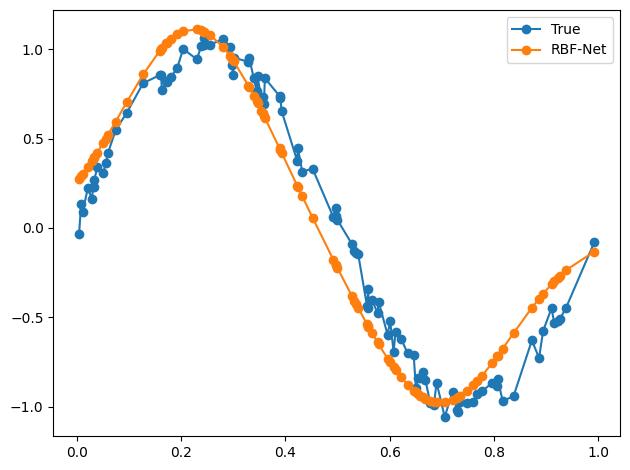

In [2]:
# Page 95 基于Python的RBF算法实现

import numpy as np  # 导入 numpy 库，用于数值计算
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot 库，用于绘图

# 定义径向基函数
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x - c)**2)  # 计算高斯径向基函数，x 是输入，c 是中心，s 是标准差

# K-Means 聚类算法
def kmeans(X, k):
    clusters = np.random.choice(np.squeeze(X), size=k)  # 随机选择 k 个初始聚类中心
    prevClusters = clusters.copy()  # 复制一份初始聚类中心，用于后续比较
    stds = np.zeros(k)  # 初始化标准差数组，长度为 k
    converged = False  # 初始化收敛标志为 False
    while not converged:
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))  # 计算每个点到每个聚类中心的距离
        closestCluster = np.argmin(distances, axis=1)  # 找到每个点最近的聚类中心
        for i in range(k):
            pointsForCluster = X[closestCluster == i]  # 获取属于第 i 个聚类中心的所有点
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)  # 更新第 i 个聚类中心为该聚类中所有点的均值
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6  # 检查聚类中心是否收敛
        prevClusters = clusters.copy()  # 更新前一轮的聚类中心
    
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))  # 再次计算每个点到每个聚类中心的距离
    closestCluster = np.argmin(distances, axis=1)  # 再次找到每个点最近的聚类中心
    clustersWithNoPoints = []  # 初始化空列表，用于存储没有点的聚类中心索引
    for i in range(k):
        pointsForCluster = X[closestCluster == i]  # 获取属于第 i 个聚类中心的所有点
        if len(pointsForCluster) < 2:
            clustersWithNoPoints.append(i)  # 如果某个聚类中心没有点或只有一个点，将其索引添加到列表中
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])  # 计算每个聚类的标准差
    
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []  # 初始化空列表，用于存储有多个点的聚类中的点
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])  # 添加有多个点的聚类中的点
        pointsToAverage = np.concatenate(pointsToAverage).ravel()  # 将所有点合并成一维数组
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))  # 计算这些点的标准差均值，并赋值给没有点的聚类中心的标准差
    
    return clusters, stds  # 返回聚类中心和标准差

# RBF 网络类
class RBFNet(object):
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k  # 中心点数量
        self.lr = lr  # 学习率
        self.epochs = epochs  # 训练轮数
        self.rbf = rbf  # 径向基函数
        self.inferStds = inferStds  # 是否从数据中推断标准差
        self.w = np.random.randn(k)  # 初始化权重
        self.b = np.random.randn(1)  # 初始化偏置
        
    def fit(self, X, y):
        if self.inferStds:
            self.centers, self.stds = kmeans(X, self.k)  # 使用 K-Means 聚类确定中心点和标准差
        else:
            self.centers, _ = kmeans(X, self.k)  # 只使用 K-Means 聚类确定中心点
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])  # 计算中心点间的最大距离
            self.stds = np.repeat(dMax / np.sqrt(2 * self.k), self.k)  # 根据最大距离计算标准差
        
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                a = np.array([self.rbf(X[i], c, s) for c, s in zip(self.centers, self.stds)])  # 计算每个输入点与中心点的径向基函数值
                F = a.T.dot(self.w) + self.b  # 计算网络输出
                loss = (y[i] - F).flatten()**2  # 计算损失
                #print('Loss: {:.2f}'.format(loss[0]))  # 打印损失（注释掉）
                error = -(y[i] - F).flatten()  # 计算误差
                self.w = self.w - self.lr * a * error  # 更新权重
                self.b = self.b - self.lr * error  # 更新偏置
                
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s in zip(self.centers, self.stds)])  # 计算每个输入点与中心点的径向基函数值
            F = a.T.dot(self.w) + self.b  # 计算网络输出
            y_pred.append(F)  # 将输出添加到预测结果列表中
        return np.array(y_pred)  # 返回预测结果

# 测试代码
NUM_SAMPLES = 100  # 定义样本数量
X = np.random.uniform(0., 1., NUM_SAMPLES)  # 生成 100 个均匀分布在 [0, 1] 之间的样本
X = np.sort(X, axis=0)  # 对样本进行排序
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)  # 生成噪声
y = np.sin(2 * np.pi * X) + noise  # 生成目标值，加上噪声

rbfnet = RBFNet(lr=1e-2, k=2, inferStds=True)  # 创建 RBF 网络实例，设置学习率、中心点数量和是否推断标准差
rbfnet.fit(X, y)  # 训练模型
y_pred = rbfnet.predict(X)  # 进行预测

plt.plot(X, y, '-o', label='True')  # 绘制真实值
plt.plot(X, y_pred, '-o', label='RBF-Net')  # 绘制预测值

plt.legend()  # 显示图例
plt.tight_layout()  # 自动调整子图布局
plt.show()  # 显示图形

#### 书中代码-Page98 基于监督学习的学习算法程序实现（补充后可运行代码）

Iteration  0  Error  1.0208361479333976
Iteration  1000  Error  7.480595727345138e-08
Iteration  2000  Error  4.693541757198313e-25
Iteration  3000  Error  5.485761420775331e-31
Iteration  4000  Error  5.146494270314487e-31
Iteration  5000  Error  5.824774592615801e-31
Iteration  6000  Error  5.485846355752308e-31
Iteration  7000  Error  2.5270619565106612e-31
Iteration  8000  Error  2.2501069536109607e-31
Iteration  9000  Error  4.52996594115679e-31
Iteration  10000  Error  6.2556711361156835e-31
Iteration  11000  Error  4.252776844840969e-31
Iteration  12000  Error  4.530062727390066e-31
Iteration  13000  Error  2.249847846108768e-31
Iteration  14000  Error  4.252736294178671e-31
Iteration  15000  Error  3.513102312109376e-31
Final Iteration Error  5.608451736219152e-31
Printing actual outputs for each pattern:
Input: [0, 0], Target: [1, 0], Actual Output: [ 1. -0.]
Input: [0, 1], Target: [0, 1], Actual Output: [-0.  1.]
Input: [1, 0], Target: [0, 1], Actual Output: [0. 1.]
Input: [1

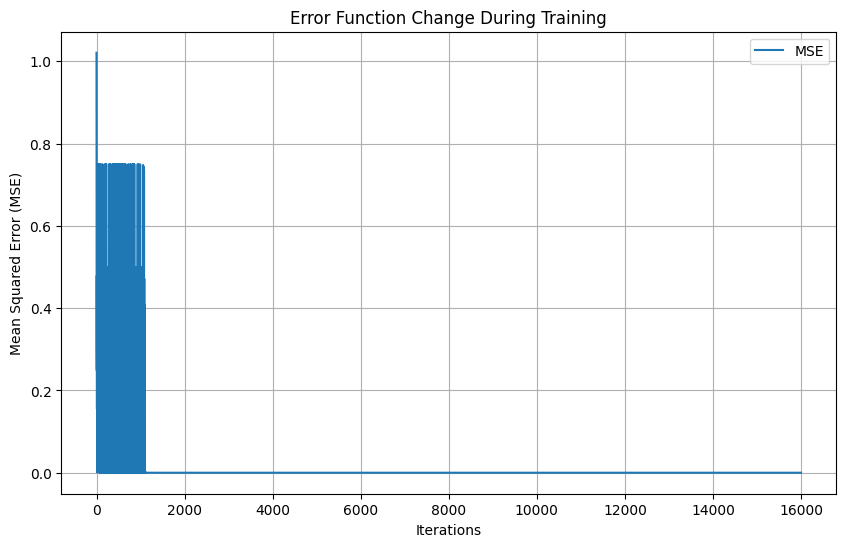

In [3]:
# Page98 基于监督学习的学习算法程序实现（补充后可运行代码）
# 测试数据似乎是在解决一个XOR二分类问题

from __future__ import division  # 确保除法运算返回浮点数
import random  # 导入随机模块，用于生成随机数
import math  # 导入数学模块，用于数学运算
import numpy as np  # 导入 numpy 库，用于数值计算
import matplotlib.pyplot as plt  # 导入 matplotlib 库，用于绘图

np.set_printoptions(suppress=True)

class RBFNetwork:
    def __init__(self, no_of_input, no_of_hidden, no_of_output, patterns, class_labels):
        self.no_of_input = no_of_input  # 输入层节点数
        self.no_of_hidden = no_of_hidden  # 隐藏层节点数
        self.no_of_output = no_of_output  # 输出层节点数
        self.patterns = patterns  # 训练数据
        self.class_labels = class_labels  # 类别标签
        self.input = np.zeros(self.no_of_input)  # 输入层节点值
        self.centroid = np.zeros((self.no_of_hidden, self.no_of_input))  # 隐藏层中心点
        self.sigma = np.zeros(self.no_of_hidden)  # 隐藏层标准差
        self.hidden_output = np.zeros(self.no_of_hidden)  # 隐藏层输出
        self.hidden_to_output_weight = np.zeros((self.no_of_hidden, self.no_of_output))  # 隐藏层到输出层的权重
        self.output = np.zeros(self.no_of_output)  # 输出层节点值
        self.output_bias = np.zeros(self.no_of_output)  # 输出层偏置
        self.actual_target_values = []  # 实际目标值
        self.total = 0  # 总和
        self.learningRate = 0.1  # 调整学习率
        self.setup_center()  # 初始化中心点
        self.setup_sigma_spread_radius()  # 初始化标准差
        self.set_up_hidden_to_ouput_weight()  # 初始化隐藏层到输出层的权重
        self.set_up_output_bias()  # 初始化输出层偏置
        self.errors = []  # 存储每次迭代后的误差

    def setup_center(self):
        """初始化中心点，目前只是在 [0, 1] 之间随机化"""
        for i in range(self.no_of_hidden):
            self.centroid[i] = np.random.uniform(0, 1, self.no_of_input)  # 随机生成中心点

    def setup_sigma_spread_radius(self):
        """初始化标准差"""
        for i in range(self.no_of_hidden):
            center = self.centroid[i]
            self.sigma[i] = self.set_up_sigma_for_center(center)  # 计算每个中心点的标准差

    def set_up_sigma_for_center(self, center):
        """计算中心点的标准差"""
        p = self.no_of_hidden / 3  # 选择最近的 1/3 个中心点
        sigma = 0
        distances = [0 for i in range(self.no_of_hidden)]  # 存储距离
        for i in range(self.no_of_hidden):
            distances[i] = self.euclidean_distance(center, self.centroid[i])  # 计算中心点之间的欧氏距离
        sum = 0
        for i in range(int(p)):
            nearest = self.get_smallest_index(distances)  # 找到最近的中心点
            distances[nearest] = float("inf")  # 将已选中的中心点距离设为无穷大
            neighbour_centroid = self.centroid[nearest]
            for j in range(len(neighbour_centroid)):
                sum += (center[j] - neighbour_centroid[j]) ** 2  # 计算平方距离和
        sigma = sum / p
        sigma = math.sqrt(sigma)  # 计算标准差
        return sigma

    @staticmethod
    def euclidean_distance(x, y):
        """计算两个向量的欧氏距离"""
        return np.linalg.norm(x - y)

    @staticmethod
    def get_smallest_index(distances):
        """找到最小距离的索引"""
        min_index = 0
        for i in range(len(distances)):
            if distances[min_index] > distances[i]:
                min_index = i
        return min_index

    def print_actual_outputs(self):
        """打印每个训练模式的实际输出"""
        print("Printing actual outputs for each pattern:")
        for pattern in self.patterns:
            input_data = pattern['input']
            self.pass_input_to_network(input_data)  # 将输入传递给网络
            output = self.output
            target = pattern['output']
            print(f"Input: {input_data}, Target: {target}, Actual Output: {output}")   
            
    def set_up_hidden_to_ouput_weight(self):
        """初始化隐藏层到输出层的权重"""
        self.hidden_to_output_weight = np.random.uniform(-0.1, 0.1, (self.no_of_hidden, self.no_of_output))  # 随机初始化权重

    def set_up_output_bias(self):
        """初始化输出层偏置"""
        self.output_bias = np.random.uniform(-0.1, 0.1, self.no_of_output)  # 随机初始化偏置

     # 训练一个周期并返回总均方误差
    def pass_one_epoch(self):
        all_error = 0
        all_index = list(range(len(self.patterns)))  # 获取所有模式的索引
        for i in range(len(self.patterns)):
            random_index = int(random.uniform(0, 1) * len(all_index))  # 随机选择一个模式
            pattern = self.patterns[random_index]  # 获取选中的模式
            del all_index[random_index]  # 删除已选中的模式索引
            input = pattern['input']
            self.actual_target_values = pattern['output']  # 设置实际目标值
            self.pass_input_to_network(input)  # 将输入传递给网络
            error = self.get_error_for_pattern()  # 计算模式的误差
            all_error += error
            self.gradient_descent()  # 使用梯度下降更新权重
        all_error /= len(self.patterns)  # 计算平均误差
        return all_error

    def pass_input_to_network(self, input):
        self.input = input
        self.pass_to_hidden_node()  # 将输入传递到隐藏层
        self.pass_to_output_node()  # 将隐藏层输出传递到输出层

    def pass_to_hidden_node(self):
        """将输入传递到隐藏层"""
        self.hidden_output = np.zeros(self.no_of_hidden)
        for i in range(len(self.hidden_output)):
            euclid_distance = self.euclidean_distance(self.input, self.centroid[i]) ** 2  # 计算欧氏距离的平方
            self.hidden_output[i] = math.exp(- (euclid_distance / (2 * self.sigma[i] ** 2)))  # 计算高斯径向基函数

    def pass_to_output_node(self):
        """将隐藏层输出传递到输出层"""
        self.output = np.zeros(self.no_of_output)
        for i in range(self.no_of_output):
            for j in range(self.no_of_hidden):
                self.output[i] += self.hidden_to_output_weight[j][i] * self.hidden_output[j]  # 计算输出层值
        # 不再进行归一化，避免梯度消失
        # total = sum(self.output)
        # for i in range(self.no_of_output):
        #     if self.output[i] != 0:
        #         self.output[i] /= total
        # self.total = total

    # 计算模式的误差
    def get_error_for_pattern(self):
        error = 0
        for i in range(len(self.output)):
            error += (self.actual_target_values[i] - self.output[i]) ** 2  # 计算均方误差
        return error

    # 使用梯度下降算法更新权重
    def gradient_descent(self):
        self.mean_error = 0
        self.error_of_output_layer = [0 for i in range(self.no_of_output)]
        for i in range(self.no_of_output):
            self.error_of_output_layer[i] = self.actual_target_values[i] - self.output[i]  # 计算输出层误差
            e = (self.actual_target_values[i] - self.output[i]) ** 2 * 0.5
            self.mean_error += e

        # 调整隐藏层到输出层的权重
        for o in range(self.no_of_output):
            for h in range(self.no_of_hidden):
                delta_weight = self.learningRate * self.error_of_output_layer[o] * self.hidden_output[h]
                self.hidden_to_output_weight[h][o] += delta_weight

        # 调整输出层偏置
        for o in range(self.no_of_output):
            delta_bias = self.learningRate * self.error_of_output_layer[o]
            self.output_bias[o] += delta_bias

        # 调整中心点
        for j in range(self.no_of_hidden):
            summ = 0
            for p in range(self.no_of_output):
                summ += self.hidden_to_output_weight[j][p] * (self.actual_target_values[p] - self.output[p])
            for i in range(self.no_of_input):
                second_part = (self.input[i] - self.centroid[j][i]) / (self.sigma[j] ** 2)
                delta_weight = self.learningRate * self.hidden_output[j] * second_part * summ
                self.centroid[j][i] += delta_weight

        # 调整标准差
        for j in range(self.no_of_hidden):
            summ = 0
            for p in range(self.no_of_output):
                summ += self.hidden_to_output_weight[j][p] * (self.actual_target_values[p] - self.output[p])
            for i in range(self.no_of_input):
                second_part = (self.input[i] - self.centroid[j][i]) ** 2 / (self.sigma[j] ** 3)
                delta_weight = 0.1 * self.learningRate * self.hidden_output[j] * second_part * summ
                self.sigma[j] += delta_weight
        return self.mean_error

    def get_accuracy_for_training(self):
        """计算训练集的准确率"""
        correct = 0
        for i in range(len(self.patterns)):
            pattern = self.patterns[i]
            self.pass_input_to_network(pattern['input'])
            n_output = self.output
            act_output = pattern['output']
            n_neuron = self.get_fired_neuron(n_output)  # 获取激活的神经元
            a_neuron = self.get_fired_neuron(act_output)  # 获取实际激活的神经元
            if n_neuron == a_neuron:
                correct += 1
        accuracy = (correct / len(self.patterns)) * 100  # 计算准确率
        return accuracy

    def get_fired_neuron(self, output):
        """获取激活的神经元"""
        max_index = 0
        for i in range(len(output)):
            if output[i] > output[max_index]:
                max_index = i
        return max_index

    # 训练 n 次迭代并记录误差
    def train(self, n):
        for i in range(n):
            error = self.pass_one_epoch()  # 训练一个周期
            self.errors.append(error)  # 记录误差
            if i % 1000 == 0:
                print("Iteration ", i, " Error ", error)  # 每1000次迭代打印当前迭代次数和误差
        print("Final Iteration Error ", error)  # 打印最终误差
        return error


# 创建测试数据
patterns = [
    {'id': 1, 'input': [0, 0], 'output': [1, 0]},
    {'id': 2, 'input': [0, 1], 'output': [0, 1]},
    {'id': 3, 'input': [1, 0], 'output': [0, 1]},
    {'id': 4, 'input': [1, 1], 'output': [1, 0]}
]

class_labels = ['0', '1']

# 创建 RBF 网络实例
rbf = RBFNetwork(2, 6, 2, patterns, class_labels)

# 训练 16000 次
mse = rbf.train(16000)

# 打印实际输出
rbf.print_actual_outputs()

# 计算训练集的准确率
accuracy = rbf.get_accuracy_for_training()

# 打印准确率和最后的均方误差
print("Total accuracy is ", accuracy)
print("Last MSE ", mse)

# 绘制误差变化图
plt.figure(figsize=(10, 6))
plt.plot(rbf.errors, label='MSE')
plt.title('Error Function Change During Training')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

#### 延展-改进后的广义RBF程序，增加了动态改变隐层径向基函数功能，使用了kmeans初始化RBF中心点，提高了网络收敛概率、加速了收敛过程。


Trying with 2 hidden nodes...
Setup completed with 2 hidden nodes.
After setup: Number of hidden nodes = 2, Centroids = [[0.66666667 0.33333333]
 [0.         1.        ]], Sigmas = [0.94280904 0.94280904]
Iteration  0  Error  0.7439691249346011
Iteration  1000  Error  0.18374243108236316
Iteration  2000  Error  0.34496744997366213
Final Iteration Error  0.1403177542791625
Trying with 4 hidden nodes...
Setup completed with 4 hidden nodes.
After setup: Number of hidden nodes = 4, Centroids = [[1. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]], Sigmas = [1. 1. 1. 1.]
Iteration  0  Error  0.6862076618958427
Iteration  1000  Error  0.007716200355640132
Iteration  2000  Error  0.0006058036586436384
Final Iteration Error  0.00021477889265184732
Converged with 4 hidden nodes.
Printing actual outputs for each pattern:
Input: [0, 0], Target: [1, 0], Actual Output: [ 1.00180541 -0.00180326]
Input: [0, 1], Target: [0, 1], Actual Output: [0.00967423 0.99033732]
Input: [1, 0], Target: [0, 1], Actual Output: [0.014

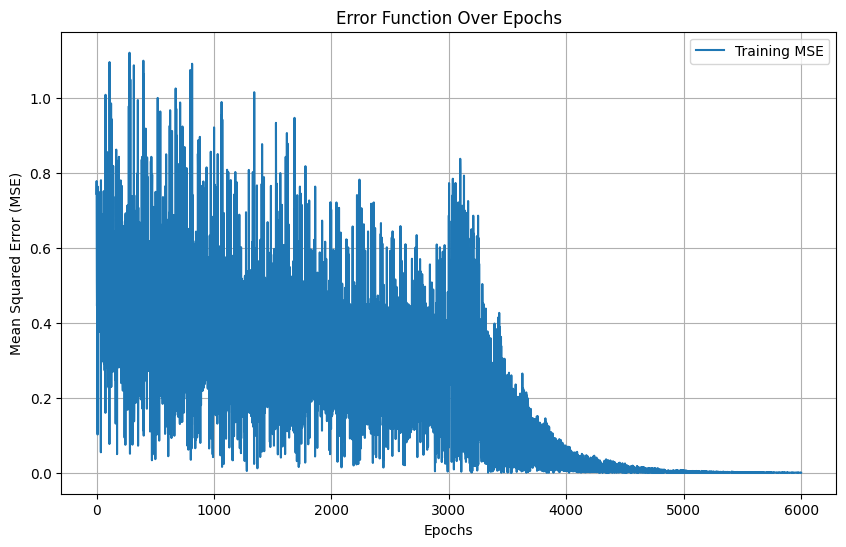

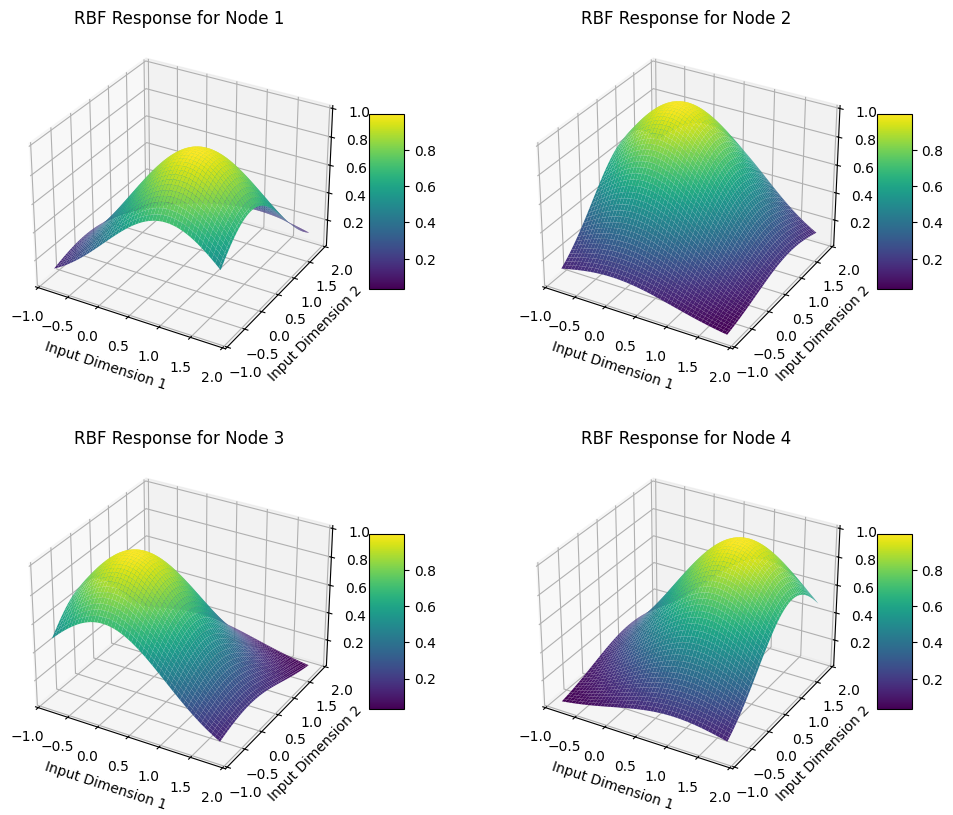

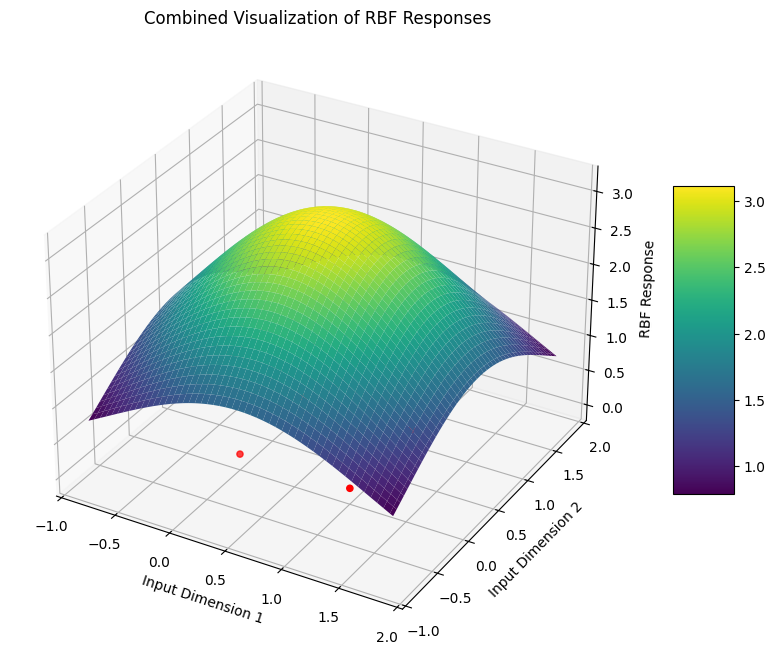

<Figure size 640x480 with 0 Axes>

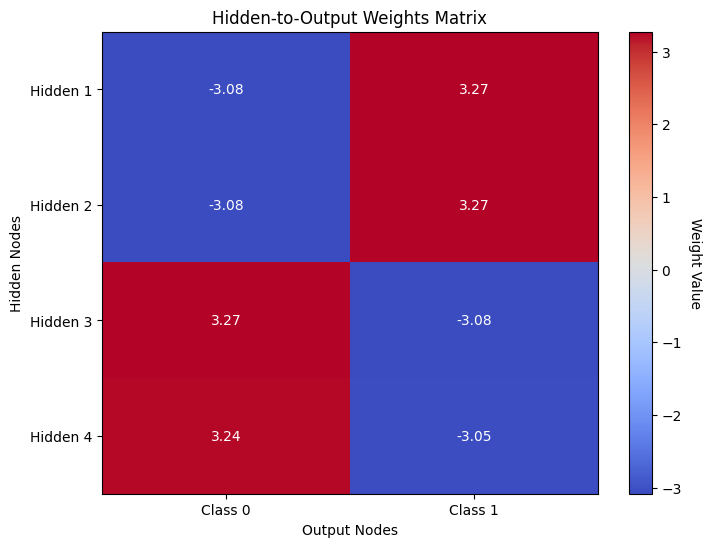

In [4]:
# 改进后的广义RBF程序，增加了动态改变隐层径向基函数功能，使用了kmeans初始化RBF中心点，提高了网络收敛概率、加速了收敛过程。

import random  # 导入随机模块，用于生成随机数
import math  # 导入数学模块，用于数学运算
import numpy as np  # 导入 numpy 库，用于数值计算
from sklearn.cluster import KMeans  # 导入KMeans聚类算法
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 导入3D绘图模块

class RBFNetwork:
    def __init__(self, no_of_input, patterns, class_labels):
        self.no_of_input = no_of_input  # 输入层节点数
        self.patterns = patterns  # 训练数据
        self.class_labels = class_labels  # 类别标签
        self.input = np.zeros(self.no_of_input)  # 输入层节点值
        self.centroid = None  # 隐藏层中心点
        self.sigma = None  # 隐藏层标准差
        self.hidden_output = None  # 隐藏层输
        self.hidden_to_output_weight = None  # 隐藏层到输出层的权重
        self.output_bias = None  # 输出层偏置
        self.output = None  # 输出层节点值
        self.actual_target_values = []  # 实际目标值
        self.total = 0  # 总和
        self.learningRate = 0.1  # 调整学习率
        self.error_history = []  # 用于存储每次迭代的误差
        self.no_of_output = len(class_labels)  # 初始化输出层节点数
        self.no_of_hidden = 0  # 初始化隐藏层节点数

    def setup_center_with_kmeans(self, n_clusters):
        """使用KMeans聚类算法初始化中心点"""
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit([pattern['input'] for pattern in self.patterns])
        self.centroid = kmeans.cluster_centers_
        self.no_of_hidden = n_clusters  # 更新隐藏层节点数
        self.setup_sigma_spread_radius()  # 初始化标准差
        self.set_up_hidden_to_output_weight()  # 初始化隐藏层到输出层的权重
        self.set_up_output_bias()  # 初始化输出层偏置
        print(f"Setup completed with {self.no_of_hidden} hidden nodes.")

    def setup_sigma_spread_radius(self):
        """初始化标准差"""
        if self.centroid is not None:
            self.sigma = np.array([self.set_up_sigma_for_center(center) for center in self.centroid])

    def set_up_sigma_for_center(self, center, k=2):
        """基于k近邻距离计算标准差"""
        distances = [self.euclidean_distance(center, c) for c in self.centroid]
        sorted_distances = np.sort(distances)[1:]  # 排除自身距离为0的情况
        sigma = np.mean(sorted_distances[:k])  # 取前k个最小距离的平均值
        return sigma

    @staticmethod
    def euclidean_distance(x, y):
        """计算两个向量的欧氏距离"""
        return np.linalg.norm(np.array(x) - np.array(y))

    def set_up_hidden_to_output_weight(self):
        """初始化隐藏层到输出层的权重"""
        if self.no_of_hidden and self.no_of_output:
            self.hidden_to_output_weight = np.random.uniform(-0.1, 0.1, (self.no_of_hidden, self.no_of_output))  # 随机初始化权重

    def set_up_output_bias(self):
        """初始化输出层偏置"""
        if self.no_of_output:
            self.output_bias = np.random.uniform(-0.1, 0.1, self.no_of_output)  # 随机初始化偏置

    def train_with_adaptive_rbf(self, max_rbf=20, min_error_threshold=0.01, epochs_per_trial=3000):
        """动态调整RBF数量以适应数据复杂度"""
        no_of_hidden = 2  # 初始RBF数量
        while no_of_hidden <= max_rbf:
            print(f"Trying with {no_of_hidden} hidden nodes...")
            self.setup_center_with_kmeans(no_of_hidden)
            print(f"After setup: Number of hidden nodes = {self.no_of_hidden}, Centroids = {self.centroid}, Sigmas = {self.sigma}")
            mse = self.train(epochs_per_trial)  # 训练并记录误差
            if mse < min_error_threshold:
                print(f"Converged with {no_of_hidden} hidden nodes.")
                break
            
            no_of_hidden += 2  # 增加RBF数量继续尝试
        else:
            print("Did not converge within the specified RBF range.")

    def train(self, n_epochs):
        """训练指定次数"""
        for i in range(n_epochs):
            error = self.pass_one_epoch()  # 训练一个周期
            self.error_history.append(error)  # 记录误差
            if i % 1000 == 0:
                print("Iteration ", i, " Error ", error)  # 每1000次迭代打印当前迭代次数和误差
        print("Final Iteration Error ", error)  # 打印最终误差
        return error

    def pass_one_epoch(self):
        all_error = 0
        all_index = list(range(len(self.patterns)))  # 获取所有模式的索引
        for i in range(len(self.patterns)):
            random_index = int(random.uniform(0, 1) * len(all_index))  # 随机选择一个模式
            pattern = self.patterns[random_index]  # 获取选中的模式
            del all_index[random_index]  # 删除已选中的模式索引
            input_data = pattern['input']
            self.actual_target_values = pattern['output']  # 设置实际目标值
            self.pass_input_to_network(input_data)  # 将输入传递给网络
            error = self.get_error_for_pattern()  # 计算模式的误差
            all_error += error
            self.gradient_descent()  # 使用梯度下降更新权重
        all_error /= len(self.patterns)  # 计算平均误差
        return all_error

    def pass_input_to_network(self, input_data):
        self.input = input_data
        self.pass_to_hidden_node()  # 将输入传递到隐藏层
        self.pass_to_output_node()  # 将隐藏层输出传递到输出层

    def pass_to_hidden_node(self):
        """将输入传递到隐藏层"""
        if self.centroid is not None and self.sigma is not None:
            self.hidden_output = np.array([math.exp(- (self.euclidean_distance(self.input, self.centroid[i]) ** 2) / (2 * self.sigma[i] ** 2)) for i in range(self.no_of_hidden)])

    def pass_to_output_node(self):
        """将隐藏层输出传递到输出层"""
        if self.hidden_output is not None and self.hidden_to_output_weight is not None:
            self.output = np.dot(self.hidden_output, self.hidden_to_output_weight) + self.output_bias

    def get_error_for_pattern(self):
        error = 0
        if self.output is not None:
            for i in range(len(self.output)):
                error += (self.actual_target_values[i] - self.output[i]) ** 2  # 计算均方误差
        return error

    def gradient_descent(self):
        if self.hidden_output is not None:
            self.mean_error = 0
            self.error_of_output_layer = np.array([self.actual_target_values[i] - self.output[i] for i in range(self.no_of_output)])
            e = sum([(self.actual_target_values[i] - self.output[i]) ** 2 * 0.5 for i in range(self.no_of_output)])
            self.mean_error += e

            # 调整隐藏层到输出层的权重
            for o in range(self.no_of_output):
                for h in range(self.no_of_hidden):
                    delta_weight = self.learningRate * self.error_of_output_layer[o] * self.hidden_output[h]
                    self.hidden_to_output_weight[h][o] += delta_weight

            # 调整输出层偏置
            for o in range(self.no_of_output):
                delta_bias = self.learningRate * self.error_of_output_layer[o]
                self.output_bias[o] += delta_bias

    def print_actual_outputs(self):
        """打印每个训练模式的实际输出"""
        print("Printing actual outputs for each pattern:")
        for pattern in self.patterns:
            input_data = pattern['input']
            self.pass_input_to_network(input_data)  # 将输入传递给网络
            output = self.output
            target = pattern['output']
            print(f"Input: {input_data}, Target: {target}, Actual Output: {output}")    

    def visualize_rbf_responses(self, resolution=100, extend_range=0.5, show_combined=True):
        """可视化所有径向基函数的响应，并扩展可视化的范围"""
        if self.centroid is None or self.sigma is None:
            print("Centroids or sigmas not initialized.")
            return
        
        # 获取输入数据的最小值和最大值，并根据extend_range参数扩展范围
        x_min, x_max = min([p['input'][0] for p in self.patterns]), max([p['input'][0] for p in self.patterns])
        y_min, y_max = min([p['input'][1] for p in self.patterns]), max([p['input'][1] for p in self.patterns])
        x_extend = (x_max - x_min) * extend_range
        y_extend = (y_max - y_min) * extend_range
        
        x = np.linspace(x_min - x_extend, x_max + x_extend, resolution)
        y = np.linspace(y_min - y_extend, y_max + y_extend, resolution)
        X, Y = np.meshgrid(x, y)

        # 如果是二维输入，则使用3D绘图
        if self.no_of_input == 2:
            # 创建一个包含所有RBF响应的列表，用于最后的组合绘制
            rbf_responses = []

            fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})
            axes = axes.flatten()  # 将axes展平为一维数组

            for i in range(self.no_of_hidden):
                rbf_response = np.exp(-((X - self.centroid[i][0]) ** 2 + (Y - self.centroid[i][1]) ** 2) / (2 * self.sigma[i] ** 2))
                rbf_responses.append(rbf_response)

                # Plot each RBF response separately to check individual contributions
                surf = axes[i].plot_surface(X, Y, rbf_response, cmap='viridis')
                axes[i].set_title(f'RBF Response for Node {i+1}')
                axes[i].set_xlabel('Input Dimension 1')
                axes[i].set_ylabel('Input Dimension 2')
                axes[i].set_zlabel('RBF Response')
                fig.colorbar(surf, ax=axes[i], shrink=0.5, aspect=5)

            if show_combined:
                # 绘制所有RBF的综合响应
                Z = sum(rbf_responses)
                fig_combined = plt.figure(figsize=(12, 8))
                ax_combined = fig_combined.add_subplot(111, projection='3d')
                surf = ax_combined.plot_surface(X, Y, Z, cmap='viridis')
                ax_combined.scatter([p['input'][0] for p in self.patterns], [p['input'][1] for p in self.patterns], [0]*len(self.patterns), c='r', marker='o')  # 标记数据点
                ax_combined.set_xlabel('Input Dimension 1')
                ax_combined.set_ylabel('Input Dimension 2')
                ax_combined.set_zlabel('RBF Response')
                ax_combined.set_title('Combined Visualization of RBF Responses')
                fig_combined.colorbar(surf, shrink=0.5, aspect=5)
                plt.show()

            plt.tight_layout()
            plt.show()

        else:
            print("Visualization only supported for 2D inputs.")

    def visualize_weights(self):
        """可视化隐藏层到输出层的权重矩阵"""
        if self.hidden_to_output_weight is None:
            print("Weights not initialized.")
            return
        
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(self.hidden_to_output_weight, cmap='coolwarm', aspect='auto')
        ax.set_xticks(np.arange(self.no_of_output))
        ax.set_yticks(np.arange(self.no_of_hidden))
        ax.set_xticklabels(self.class_labels)
        ax.set_yticklabels([f'Hidden {i+1}' for i in range(self.no_of_hidden)])
        ax.set_xlabel('Output Nodes')
        ax.set_ylabel('Hidden Nodes')
        ax.set_title('Hidden-to-Output Weights Matrix')

        # 添加颜色条
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('Weight Value', rotation=-90, va="bottom")

        # 在每个单元格中显示权重值
        for i in range(self.no_of_hidden):
            for j in range(self.no_of_output):
                text = ax.text(j, i, f'{self.hidden_to_output_weight[i, j]:.2f}', ha='center', va='center', color='w')

        plt.show()

# 创建测试数据
patterns = [
    {'id': 1, 'input': [0, 0], 'output': [1, 0]},
    {'id': 2, 'input': [0, 1], 'output': [0, 1]},
    {'id': 3, 'input': [1, 0], 'output': [0, 1]},
    {'id': 4, 'input': [1, 1], 'output': [1, 0]}
]

class_labels = ['Class 0', 'Class 1']

# 创建 RBF 网络实例
rbf = RBFNetwork(2, patterns, class_labels)

# 使用动态调整RBF数量的方法进行训练
rbf.train_with_adaptive_rbf(max_rbf=4, min_error_threshold=0.01, epochs_per_trial=3000)

# 打印实际输出
rbf.print_actual_outputs()

# 可视化误差函数变化
def plot_error_history(rbf):
    """绘制误差随迭代次数的变化"""
    epochs = range(len(rbf.error_history))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, rbf.error_history, label='Training MSE')
    plt.title('Error Function Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 调用函数以绘制误差变化图
plot_error_history(rbf)

# 可视化各径向基函数，并扩展显示范围
rbf.visualize_rbf_responses(extend_range=0.85)

# 可视化隐藏层到输出层的权重矩阵
rbf.visualize_weights()

#### 延展-可视化径向基函数分布与合成关系

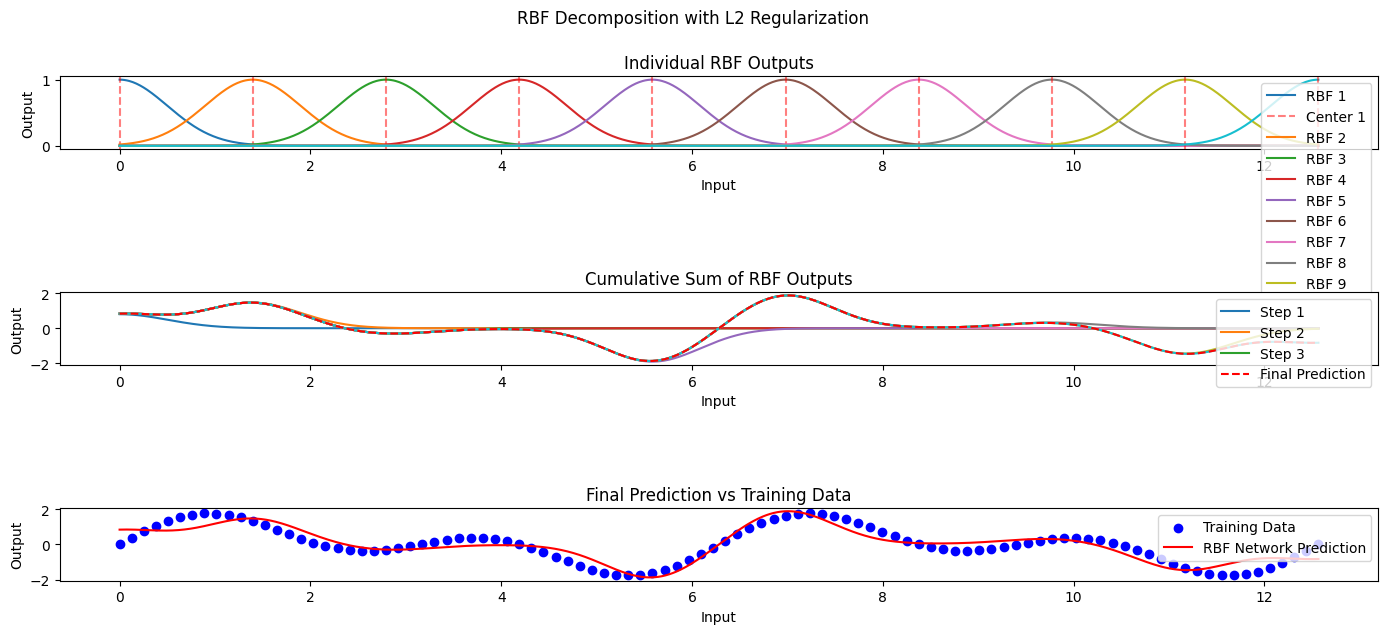

In [5]:
# 延展-可视化径向基函数分布与合成关系

import numpy as np
import matplotlib.pyplot as plt

class RBFNetwork:
    def __init__(self, centers, sigma, lambda_reg=0.01):
        self.centers = centers
        self.sigma = sigma
        self.lambda_reg = lambda_reg  # 正则化参数
        self.weights = None

    def rbf(self, x, c):
        """计算径向基函数"""
        return np.exp(-np.sum((x - c) ** 2) / (2 * self.sigma ** 2))

    def fit(self, X, Y):
        """拟合模型，使用L2正则化"""
        m = len(X)
        # 创建设计矩阵
        G = np.zeros((m, len(self.centers)))
        for i in range(m):
            for j in range(len(self.centers)):
                G[i, j] = self.rbf(X[i], self.centers[j])

        # 计算带有L2正则化的权重
        GTG = G.T.dot(G)
        reg_term = self.lambda_reg * np.eye(GTG.shape[0])
        self.weights = np.linalg.solve(GTG + reg_term, G.T.dot(Y))

    def predict(self, X):
        """预测新数据"""
        m = len(X)
        G = np.zeros((m, len(self.centers)))
        for i in range(m):
            for j in range(len(self.centers)):
                G[i, j] = self.rbf(X[i], self.centers[j])
        return G.dot(self.weights), G  # 返回预测结果和RBF输出矩阵

def plot_rbf_decomposition(X_test, rbf_outputs, centers, predictions, weights, y_train, X_train, title="RBF Decomposition"):
    """绘制每个RBF的输出及其逐层叠加的效果"""
    n_centers = len(centers)
    
    fig = plt.figure(figsize=(14, 6))
    
    # 绘制每个RBF的输出及对应的中心点位置
    ax1 = plt.subplot(3, 1, 1)
    for i in range(n_centers):
        ax1.plot(X_test, rbf_outputs[:, i], label=f'RBF {i+1}')
        ax1.axvline(x=centers[i], color='red', linestyle='--', alpha=0.5, label=f'Center {i+1}' if i == 0 else "")
    
    ax1.set_title("Individual RBF Outputs")
    ax1.set_xlabel('Input')
    ax1.set_ylabel('Output')
    ax1.legend(loc='upper right')

    # 逐步累加RBF输出，展示每一步的合成效果
    ax2 = plt.subplot(3, 1, 2)
    cumulative_sum = np.zeros_like(predictions.flatten())
    for i in range(n_centers):
        cumulative_sum += rbf_outputs[:, i] * weights[i]
        ax2.plot(X_test, cumulative_sum, label=f'Step {i+1}' if i < 3 else "")  # 只标记前几个步骤
    
    ax2.plot(X_test, predictions, color='red', linestyle='--', label='Final Prediction')
    ax2.set_title("Cumulative Sum of RBF Outputs")
    ax2.set_xlabel('Input')
    ax2.set_ylabel('Output')
    ax2.legend(loc='upper right')

    # 展示所有RBF的总和与训练数据的对比，以及最终的拟合曲线
    ax3 = plt.subplot(3, 1, 3)
    ax3.scatter(X_train, y_train, color='blue', label='Training Data')
    ax3.plot(X_test, predictions, color='red', label='RBF Network Prediction')
    ax3.set_title("Final Prediction vs Training Data")
    ax3.set_xlabel('Input')
    ax3.set_ylabel('Output')
    ax3.legend(loc='upper right')

    plt.tight_layout()
    plt.suptitle(title, y=1.05)
    plt.show()

# 生成训练数据
X_train = np.linspace(0, 4 * np.pi, 100)
y_train = np.sin(X_train) + np.sin(2 * X_train)

# 预定义的中心点和宽度
centers = np.linspace(0, 4 * np.pi, 10)  # 减少一些中心点以便更清晰地展示
sigma = 0.5  # 根据经验调整宽度

# 创建并训练带有正则化的RBF网络
rbf_network = RBFNetwork(centers, sigma, lambda_reg=0.01)
rbf_network.fit(X_train[:, np.newaxis], y_train[:, np.newaxis])

# 测试/预测
X_test = np.linspace(0, 4 * np.pi, 1000)[:, np.newaxis]
predictions, rbf_outputs = rbf_network.predict(X_test)

# 可视化分解后的RBF输出及其合成关系
plot_rbf_decomposition(
    X_test.flatten(), 
    rbf_outputs, 
    centers, 
    predictions.flatten(), 
    rbf_network.weights,  # 传递权重
    y_train, 
    X_train, 
    title="RBF Decomposition with L2 Regularization"
)